It is still slightly different from the pyre version: need monitors. 
After that we should be able to run the beam postprocessing step. Right now it fails.

# Calculate beam intensity and resolution vs FC freq

In [1]:
import os, numpy as np
import histogram.hdf as hh
import mcvine, mcvine.components, mcvine.run_script

from matplotlib import pyplot as plt
%matplotlib notebook

In [14]:
from mcni.utils import conversion as C

In [2]:
workdir = os.path.expanduser("/SNS/users/lj7/dv/sns-chops/resolution/ARCS/mcvine/Ei_400")
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/resolution/ARCS/mcvine/Ei_400


# Create instrument sim app

In [65]:
%%file arcs_mcvine.py

import numpy as np
from numpy import power as pow, sqrt, log10, tanh
import mcvine, mcvine.components as mcomps

def instrument(
    Edes=None, Emin=None, Emax=None, moderator_file=None, T0_nu=60., 
    fc_nchan=31., fc_w=0.060364, fc_bw=0.00041, fc_blader=0.5801,
    Fermi_nu=600.
):
    from mcni.utils.conversion import SE2V
    LT0=8.77;LF=11.61;LM1=11.82;LM2=18.50;LS=13.61;L3=3.5;
    # /*determine emission time of certain energy neutrons after the prompt pulse */
    # import pdb; pdb.set_trace()
    ch_x=log10(Edes*1e-3);  
    ch_y=-0.4420*ch_x*(1+tanh((ch_x+1.1197)/0.4042))/2-0.1235*ch_x*(1-tanh((ch_x+1.1197)/0.4042))/2-0.4189*tanh((ch_x+1.1197)/0.4042)+0.5612;
    # // toffset=0.0;
    toffset=pow(10,ch_y)/1.0e6;
    # /*set phases for the critical lengths */
    phasefc1=(LF)/(sqrt(Edes)*SE2V)+toffset;
    phase_T0=(LT0)/(sqrt(Edes)*SE2V)+toffset;
    phase_sam=(LS)/(sqrt(Edes)*SE2V)+toffset;
    phase_det=(LS+L3)/(sqrt(Edes)*SE2V)+toffset;
    phase_m1=(LM1)/(sqrt(Edes)*SE2V)+toffset;
    phase_m2=(LM2)/(sqrt(Edes)*SE2V)+toffset;
    # /* set parameters for guide reflectivity profile */
    Gu_R=0.98;Gu_alpha=5.5;Gu_m=3.6;Gu_Qc=0.02;Gu_W=2e-3;
    # /* set energy range to examine  set to +/- 20% of Edes value*/
    Emin=Emin if Emin is not None else Edes*0.8
    Emax=Emax if Emax is not None else Edes*1.2
    # //tplotw=((0.06-0.0005)/nchans-0.0005)/(4.0*PI*Fermi_nu*0.05)*4.0;
    tplotmin=LM1/(sqrt(Emax)*SE2V)+toffset;
    tplotmax=LM1/(sqrt(Emin)*SE2V)+toffset;

    instrument = mcvine.instrument()

    mod = mcomps.sources.SNS_source(
        name='mod', yh=0.12, dist=2.5, Emin=Emin, Emax=Emax, height=0.12, width=0.1, 
        S_filename=moderator_file, xw=0.1)
    instrument.append(mod, position=(0,0,0), orientation=(0, 0, 0))

    core_ves = mcomps.optics.Guide_channeled(name='core_ves', Qcx=Gu_Qc, R0=0.0, W=Gu_W, alphay=Gu_alpha, h2=0.102362, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.11323, l=1.2444, w2=0.084684, w1=0.094285, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(core_ves, position=(0.0, 0.0, 1.0106), orientation=(0, 0, 0), relativeTo=mod)

    shutter_guide = mcomps.optics.Guide_channeled(name='shutter_guide', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.086880, alphax=Gu_alpha, Qcy=Gu_Qc, h1=.094040, l=1.853, w2=0.070880, w1=0.074930, k=1, my=2.5, mx=2.5, d=0.0)
    instrument.append(shutter_guide, position=(0.0, 0.0, 2.2679), orientation=(0, 0, 0), relativeTo=mod)

    Guide_1_1_1 = mcomps.optics.Guide_channeled(name='Guide_1_1_1', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.08573, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.08688, l=0.48354, w2=0.07019, w1=0.07088, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_1_1_1, position=(0.0, 0.0, 4.1723), orientation=(0, 0, 0), relativeTo=mod)

    Guide_1_1_2 = mcomps.optics.Guide_channeled(name='Guide_1_1_2', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.08454, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.08573, l=0.48354, w2=0.06947, w1=0.07019, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_1_1_2, position=(0.0, 0.0, 4.65589), orientation=(0, 0, 0), relativeTo=mod)

    Guide_1_1_3 = mcomps.optics.Guide_channeled(name='Guide_1_1_3', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.08329, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.08454, l=0.48354, w2=0.06871, w1=0.06947, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_1_1_3, position=(0.0, 0.0, 5.13948), orientation=(0, 0, 0), relativeTo=mod)

    Guide_1_2_1 = mcomps.optics.Guide_channeled(name='Guide_1_2_1', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.08197, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.08329, l=0.48354, w2=0.06792, w1=0.06871, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_1_2_1, position=(0.0, 0.0, 5.62331), orientation=(0, 0, 0), relativeTo=mod)

    Guide_1_2_2 = mcomps.optics.Guide_channeled(name='Guide_1_2_2', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.08060, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.08197, l=0.48354, w2=0.06710, w1=0.06792, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_1_2_2, position=(0.0, 0.0, 6.1069), orientation=(0, 0, 0), relativeTo=mod)

    Guide_1_2_3 = mcomps.optics.Guide_channeled(name='Guide_1_2_3', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.07917, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.08060, l=0.48354, w2=0.06624, w1=0.06710, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_1_2_3, position=(0.0, 0.0, 6.59049), orientation=(0, 0, 0), relativeTo=mod)

    Guide_1_3_1 = mcomps.optics.Guide_channeled(name='Guide_1_3_1', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.07766, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.07917, l=0.48354, w2=0.06534, w1=0.06624, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_1_3_1, position=(0.0, 0.0, 7.07433), orientation=(0, 0, 0), relativeTo=mod)

    Guide_1_3_2 = mcomps.optics.Guide_channeled(name='Guide_1_3_2', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.07609, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.07766, l=0.48354, w2=0.06440, w1=0.06534, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_1_3_2, position=(0.0, 0.0, 7.55792), orientation=(0, 0, 0), relativeTo=mod)

    Guide_1_3_3 = mcomps.optics.Guide_channeled(name='Guide_1_3_3', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.07443, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.07609, l=0.48354, w2=0.06342, w1=0.06440, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_1_3_3, position=(0.0, 0.0, 8.04145), orientation=(0, 0, 0), relativeTo=mod)

    t0_chopp = mcomps.optics.Vertical_T0(name='t0_chopp', ymax=0.045, len=0.474, tc=phase_T0, w2=0.101, w1=0.08, delta=0.0, ymin=-0.045, nu=T0_nu)
    instrument.append(t0_chopp, position=(0,0,LT0), orientation=(0, 0, 0))

    Guide_2_1_1 = mcomps.optics.Guide_channeled(name='Guide_2_1_1', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.06936, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.07094, l=0.40204, w2=0.06044, w1=0.06136, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_2_1_1, position=(0.0, 0.0, 9.47504), orientation=(0, 0, 0), relativeTo=mod)

    Guide_2_1_2 = mcomps.optics.Guide_channeled(name='Guide_2_1_2', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.06771, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.06936, l=0.40204, w2=0.05948, w1=0.06044, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_2_1_2, position=(0.0, 0.0, 9.87713), orientation=(0, 0, 0), relativeTo=mod)

    Guide_2_3_3 = mcomps.optics.Guide_channeled(name='Guide_2_3_3', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.06598, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.06771, l=0.40204, w2=0.05848, w1=0.05948, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_2_3_3, position=(0.0, 0.0, 10.27922), orientation=(0, 0, 0), relativeTo=mod)

    Guide_1_3_4 = mcomps.optics.Guide_channeled(name='Guide_1_3_4', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.06417, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.06598, l=0.40204, w2=0.05745, w1=0.05848, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_1_3_4, position=(0.0, 0.0, 10.68131), orientation=(0, 0, 0), relativeTo=mod)

    Guide_2_1_5 = mcomps.optics.Guide_channeled(name='Guide_2_1_5', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.06227, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.06417, l=0.40204, w2=0.05637, w1=0.05745, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_2_1_5, position=(0.0, 0.0, 11.0834), orientation=(0, 0, 0), relativeTo=mod)

    fermi_chopp = mcomps.optics.Fermi_chop2(
        name='fermi_chopp', 
        ymin=-.0325, ymax=.0325, len=0.10,
        delta=0.0, tc=phasefc1, 
        nchan=fc_nchan, w=fc_w, bw=fc_bw, blader=fc_blader,
        nu=Fermi_nu)
    instrument.append(fermi_chopp, position=(0.0, 0.0, LF), orientation=(0, 0, 0), relativeTo=mod)

    Monitor1 = mcomps.monitors.TOF_monitor2(
        name='Monitor1', nchan=1000, tmin=0, tmax=0.016,
        ymax=0.035, filename='mon1.dat', xmax=0.035, xmin=-0.035, ymin=-0.035)
    instrument.append(Monitor1, position=(0.0, 0.0, LM1), orientation=(0, 0, 0), relativeTo=mod)

    Guide_3_1_1 = mcomps.optics.Guide_channeled(name='Guide_3_1_1', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.05931, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.06046, l=0.225, w2=0.05473, w1=0.05536, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_3_1_1, position=(0.0, 0.0, 11.84975), orientation=(0, 0, 0), relativeTo=mod)

    Guide_4_1_1 = mcomps.optics.Guide_channeled(name='Guide_4_1_1', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.05674, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.05924, l=0.46275, w2=0.05331, w1=0.05468, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_4_1_1, position=(0.0, 0.0, 12.08825), orientation=(0, 0, 0), relativeTo=mod)

    Guide_4_1_2 = mcomps.optics.Guide_channeled(name='Guide_4_1_2', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.05408, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.05674, l=0.46275, w2=0.05187, w1=0.05331, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_4_1_2, position=(0.0, 0.0, 12.55105), orientation=(0, 0, 0), relativeTo=mod)

    Guide_5_1_1 = mcomps.optics.Guide_channeled(name='Guide_5_1_1', Qcx=Gu_Qc, R0=Gu_R, W=Gu_W, alphay=Gu_alpha, h2=0.05172, alphax=Gu_alpha, Qcy=Gu_Qc, h1=0.05405, l=0.37920, w2=0.05062, w1=0.05186, k=1, my=Gu_m, mx=Gu_m, d=0.0)
    instrument.append(Guide_5_1_1, position=(0.0, 0.0, 13.0183), orientation=(0, 0, 0), relativeTo=mod)

    E_det = mcomps.monitors.E_monitor(
        name='E_det', nchan=200, 
        # Emin=0, Emax=1000.,
        Emin=Emin, Emax=Emax,
        filename='E.dat', xmax=.035, xmin=-.035, ymin=-.035, ymax=.035, )
    instrument.append(E_det, position=(0.0, 0.0, LS-.151), orientation=(0, 0, 0), relativeTo=mod)

    recorder = mcomps.monitors.NeutronToStorage('recorder', 'neutrons')
    instrument.append(recorder, position=(0,0,LS-0.15), orientation=(0,0,0), relativeTo=mod)
    return instrument

Overwriting arcs_mcvine.py


# Run sim

T0_nu value: see check-V-data.ipynb

In [47]:
%%file params.yaml
moderator_file: /SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/resources/instruments/ARCS/moderator/source_sct521_bu_17_1.dat
Edes: 400.
T0_nu: 180.
Fermi_nu: 600.
fc_nchan: 31.
fc_w: 0.060364
fc_bw: 0.00041
fc_blader: 0.5801

Overwriting params.yaml


In [6]:
ls

arcs_mcvine.py  params.yaml


In [7]:
!python -m "mcvine.run_script" arcs_mcvine.py --help

Usage: run_script.py [OPTIONS] SCRIPT

Options:
  --workdir TEXT           work directory
  --ncount INTEGER         neutron count
  --overwrite_datafiles    overwrite datafiles
  --buffer_size INTEGER    neutron buffer size
  --mpi-mode TEXT
  --nodes INTEGER
  --run-pps                run post-processing script. only valid for None mpi
                           mode
  --additional-kargs TEXT  addiontal kwd args in a yaml file
  --help                   Show this message and exit.


In [54]:
rm -rf 1e8/

In [63]:
rm -rf 1e6/

In [66]:
%%time
ncount = "1e6"
buffer_size = "1e5"
nodes = 10
!python -m "mcvine.run_script" arcs_mcvine.py \
    --workdir {ncount} --overwrite_datafiles \
    --ncount {int(float(ncount))} --buffer_size {int(float(buffer_size))}  --mpi-mode server --nodes {nodes}\
    --run-pps \
    --additional-kargs params.yaml

Loading moderator file /SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/resources/instruments/ARCS/moderator/source_sct521_bu_17_1.dat
/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/resources/instruments/ARCS/moderator/source_sct521_bu_17_1.dat
Loading moderator file /SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/resources/instruments/ARCS/moderator/source_sct521_bu_17_1.dat
/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/resources/instruments/ARCS/moderator/source_sct521_bu_17_1.dat
Loading moderator file /SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/resources/instruments/ARCS/moderator/source_sct521_bu_17_1.dat
/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/resources/instruments/ARCS/moderator/source_sct521_bu_17_1.dat
Loading moderator file /SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/resources/instruments/ARCS/moderator/source_sct521_bu_17_1.dat
/SNS/software/miniconda2/envs/mcvine-unstable/share/mc

finalize component "Monitor1"
finalize component "Guide_3_1_1"
finalize component "Guide_4_1_1"
finalize component "Guide_4_1_2"
finalize component "Guide_5_1_1"
<E> : 405.691 meV , E-width : 8.48895 meV 
E_monitor: saved data to file 'E.dat'.
E_monitor: finalized.
finalize component "E_det"
finalize component "mod"
finalize component "core_ves"
finalize component "shutter_guide"
finalize component "Guide_1_1_1"
finalize component "Guide_1_1_2"
finalize component "Guide_1_1_3"
finalize component "Guide_1_2_1"
finalize component "Guide_1_2_2"
finalize component "Guide_1_2_3"
finalize component "Guide_1_3_1"
finalize component "Guide_1_3_2"
finalize component "Guide_1_3_3"
finalize component "t0_chopp"
finalize component "Guide_2_1_1"
finalize component "Guide_2_1_2"
finalize component "Guide_2_3_3"
finalize component "Guide_1_3_4"
finalize component "Guide_2_1_5"
finalize component "fermi_chopp"
finalize component "mod"
finalize component "core_ves"
finalize component "shutter_guide"
fi

In [68]:
ls 1e6

E.h5                      rank2-step0/  rank4-step4/  rank7-step3/
mon1.h5                   rank2-step1/  rank5-step0/  rank7-step4/
neutrons                  rank2-step2/  rank5-step1/  rank8-step0/
post-processing-scripts/  rank2-step3/  rank5-step2/  rank8-step1/
rank0-step0/              rank2-step4/  rank5-step3/  rank8-step2/
rank0-step1/              rank3-step0/  rank5-step4/  rank8-step3/
rank0-step2/              rank3-step1/  rank6-step0/  rank8-step4/
rank0-step3/              rank3-step2/  rank6-step1/  rank9-step0/
rank0-step4/              rank3-step3/  rank6-step2/  rank9-step1/
rank1-step0/              rank3-step4/  rank6-step3/  rank9-step2/
rank1-step1/              rank4-step0/  rank6-step4/  rank9-step3/
rank1-step2/              rank4-step1/  rank7-step0/  rank9-step4/
rank1-step3/              rank4-step2/  rank7-step1/
rank1-step4/              rank4-step3/  rank7-step2/


In [70]:
from mcvine.instruments.SEQUOIA import beam_postprocessing as bpp
bpp.run('./1e6', './1e6-with-metadata', 400.)

IOError: unable to load histogram. filename=./1e6/mon1-tof.h5, pathinfile=I(tof), kwds={}

<IPython.core.display.Javascript object>


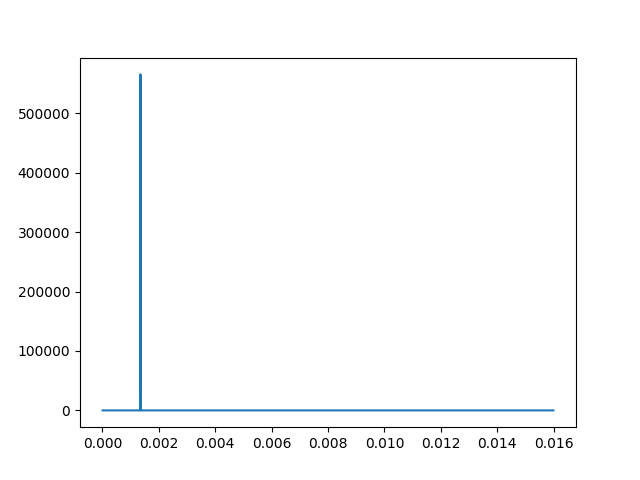

In [57]:
Itof = hh.load('./1e8/mon1.h5')
plt.figure()
plt.plot(Itof.tof, Itof.I)

<IPython.core.display.Javascript object>


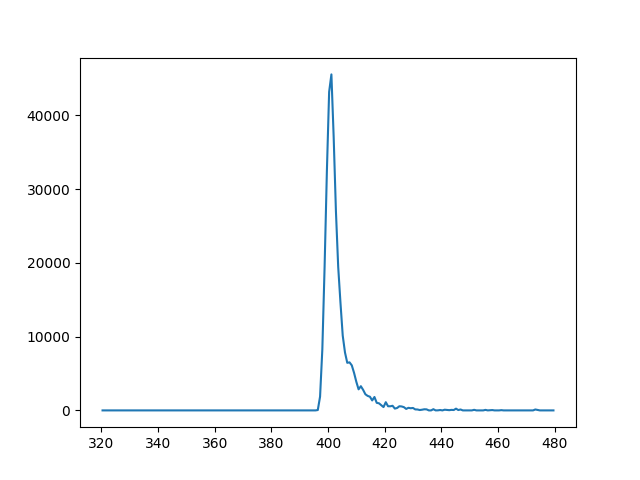

In [58]:
IE = hh.load('./1e8/E.h5')
plt.figure()
plt.plot(IE.energy, IE.I)